# It's Corn (PogChamps \#3) Kaggle Competition - Experiment 3

## Setup Competition Files

In [1]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [2]:
comp = 'kaggle-pog-series-s01e03'

In [3]:
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')


In [4]:
import timm
from fastai.vision.all import *
set_seed(42)

path.ls()

(#1) [Path('kaggle-pog-series-s01e03/corn')]

In [5]:
trn_path = path/'corn'/'train'
trn_path.ls()

(#14322) [Path('kaggle-pog-series-s01e03/corn/train/08602.png'),Path('kaggle-pog-series-s01e03/corn/train/06377.png'),Path('kaggle-pog-series-s01e03/corn/train/12836.png'),Path('kaggle-pog-series-s01e03/corn/train/05256.png'),Path('kaggle-pog-series-s01e03/corn/train/03056.png'),Path('kaggle-pog-series-s01e03/corn/train/00938.png'),Path('kaggle-pog-series-s01e03/corn/train/02865.png'),Path('kaggle-pog-series-s01e03/corn/train/02323.png'),Path('kaggle-pog-series-s01e03/corn/train/09385.png'),Path('kaggle-pog-series-s01e03/corn/train/10855.png')...]

In [6]:
tst_path = path/'corn'/'test'
tst_path.ls()

(#3479) [Path('kaggle-pog-series-s01e03/corn/test/02921.png'),Path('kaggle-pog-series-s01e03/corn/test/17570.png'),Path('kaggle-pog-series-s01e03/corn/test/01816.png'),Path('kaggle-pog-series-s01e03/corn/test/07985.png'),Path('kaggle-pog-series-s01e03/corn/test/04347.png'),Path('kaggle-pog-series-s01e03/corn/test/02109.png'),Path('kaggle-pog-series-s01e03/corn/test/09175.png'),Path('kaggle-pog-series-s01e03/corn/test/01604.png'),Path('kaggle-pog-series-s01e03/corn/test/14128.png'),Path('kaggle-pog-series-s01e03/corn/test/01616.png')...]

Grab csv lists

In [7]:
csv_path = path/'corn'
train_csv_fname = csv_path/'train.csv'
train = pd.read_csv(train_csv_fname)
test_csv_fname = csv_path/'test.csv'
test = pd.read_csv(test_csv_fname)
ss_csv_fname = csv_path/'sample_submission.csv'
ss = pd.read_csv(ss_csv_fname)

## Check image sizes
Check all the image sizes.  This is faster in parallel.  Using fastcore's `parallel` for this:

In [8]:
files = get_image_files(trn_path)

In [9]:
print (f"Total number of train images: {len(files)}")

Total number of train images: 14322


In [10]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
# AMD Ryzen 9 5900X 12-Cores / 24-Threads
sizes = parallel(f, files, n_workers=24)
pd.Series(sizes).value_counts()

(132, 132)    187
(140, 136)    187
(136, 132)    168
(136, 136)    166
(128, 132)    165
             ... 
(136, 121)      1
(140, 104)      1
(208, 168)      1
(104, 180)      1
(204, 164)      1
Length: 784, dtype: int64

Get image widths and heights and find the max of both for padding purposes.

Note size elements are in the structure (width, height) according to [here](https://note.nkmk.me/en/python-opencv-pillow-image-size/).

In [11]:
def get_widths(size): return size[0]
widths = parallel(get_widths, sizes, n_workers=24)
max_width = pd.Series(widths).max()
print(f'max width: {max_width}')

max width: 224


In [12]:
def get_heights(size): return size[1]
heights = parallel(get_heights, sizes, n_workers=24)
max_height = pd.Series(heights).max()
print(f'max height: {max_height}')

max height: 228


## Check GPU Usage and Clean Memory Helper Function

When running experiments the model and data batches are loaded onto the GPU.  This can make running multiple experiments with larger models cause the GPU to run out of memory.  This helper function will print out the ammount of memory being used by the GPU (via `torch.cuda.list_gpu_processes()` and run the python garbage collector `gc.collect()` followed by a call to empty the GPU memory `torch.cuda.empty_cache()`.

In [13]:
import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

In [14]:
report_gpu()

GPU:0
no processes are running


## Model Experimentation

Let's experiment with some different architectures and image processing approaches (item and batch transforms).  In order to make this easier lets make a function that takes care of common modelling steps that we can hand different architectures, item transforms and batch transforms to:

In [15]:
def train(arch, item, batch, epochs=5):
    dls = ImageDataLoaders.from_csv(csv_path, 
        csv_fname='train.csv', valid_pct=0.2,
        seed=42, fn_col=2, label_col=3,
        item_tfms=item, batch_tfms=batch)
    learn = vision_learner(dls, arch,
        metrics=[error_rate,accuracy]).to_fp16()
    learn.fine_tune(epochs, 0.01)
    return learn

## A ConvNeXt model

Again looking at [efficient models for fine tuning](https://www.kaggle.com/code/jhoward/the-best-vision-models-for-fine-tuning) `convnext_small` tops the performance/accuracy tradeoff score.  Let's try it!

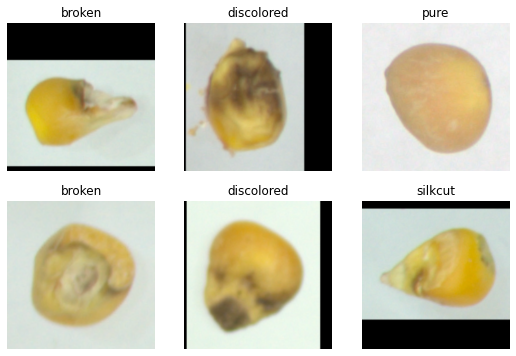

In [16]:
dls = ImageDataLoaders.from_csv(csv_path, 
    csv_fname='train.csv', valid_pct=0.2, seed=42,
    fn_col=2, label_col=3,
    item_tfms=Resize(256, method=ResizeMethod.Pad,
    pad_mode=PadMode.Zeros),
    batch=aug_transforms(size=(128,128), min_scale=1))

dls.show_batch(max_n=6)

In [17]:
# Report/Free GPU Memory
report_gpu()

GPU:0
process     175735 uses      903.000 MB GPU memory


In [18]:
arch = 'convnext_large_in22k'

learn = train(arch, item=Resize((256,256),
    method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
    batch=aug_transforms(size=(256,256), min_scale=1.0))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.988215,0.880988,0.295042,0.704958,01:11


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.649782,0.641781,0.253142,0.746858,01:37
1,0.606046,0.615673,0.229050,0.770950,01:37
2,0.466097,0.579329,0.229399,0.770601,01:37
3,0.316131,0.639807,0.226955,0.773045,01:37
4,0.217825,0.632294,0.214036,0.785964,01:37


In [36]:
# Report/Free GPU Memory
if 'learn' in locals(): del learn
report_gpu()

GPU:0
process     175735 uses     5845.000 MB GPU memory


Let's see what happens when we use less aggressive augmentations.  As some reasonable inter-class confusion could be happening due to lighting changes causing a kernel to appear healthy/defective, cropping removing the kernel damage, etc.

In [20]:
learn = train(arch, item=Resize((256,256),
    method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
    batch=aug_transforms(size=(256,256), min_scale=1,
        max_zoom=0.0, max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=0.0))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.923563,0.788784,0.292598,0.707402,01:10


epoch,train_loss,valid_loss,error_rate,accuracy,time


RuntimeError: CUDA out of memory. Tried to allocate 24.00 MiB (GPU 0; 23.69 GiB total capacity; 21.52 GiB already allocated; 21.88 MiB free; 21.79 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Test time augmentation

In [ ]:
valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)

In [ ]:
error_rate(preds, targs)

In [ ]:
accuracy(preds, targs)

That's the same error rate and accuracy in the run above so we know this is done correctly.

Let's take a look at what our data augmentation is doing.

In [ ]:
learn.dls.train.show_batch(max_n=6, unique=True)

These images are all rotated, flipped, warped, zoomed, slightly lighter or darker.

If we call tta() then we'll get the average predictiosn made for multiple different augmented versions of each image, along with the unaugmented original:

In [ ]:
tta_preds,_ = learn.tta(dl=valid)

Let's check the error rate with TTA:

In [ ]:
error_rate(tta_preds, targs)

In [ ]:
accuracy(tta_preds, targs)

This seems to make an improvement.  Likely want to add this to submissions we make.  Thinking that some of the augmentations might be pushing features of some images into othe classes (by cropping the damage, making the colour lighter/darker, etc).  May need to look into simpler augmentations.

In [ ]:
# Report/Free GPU Memory
report_gpu()

## Scaling up

Let's try to scale up to larger images and more epochs.  We can switch to keeping (256,256) padded images, with final augmented images:

Unfortunately, validation loss is jumpy from the beginning and starts showing signs of overfitting well before the 12th iteration.  Let's try making a version of our helper function that uses the auto learning rate finder to set a learning rate that might be better (if conservative).

In [ ]:
def train_auto_loss(arch, item, batch, epochs=5):
    dls = ImageDataLoaders.from_csv(csv_path, 
        csv_fname='train.csv', valid_pct=0.2,
        seed=42, fn_col=2, label_col=3,
        item_tfms=item, batch_tfms=batch)
    learn = vision_learner(dls, arch,
        metrics=[error_rate,accuracy]).to_fp16()
    _valley, _slide = learn.lr_find(suggest_funcs=(valley,slide))
    learn.fine_tune(epochs, _slide)
    return learn

In [ ]:
learn = train_auto_loss(arch, epochs=12, item=Resize((256,256),
    method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
    batch=aug_transforms(size=(256,256), min_scale=1,
        max_zoom=0.0, max_lighting=0.0, p_lighting=0.0,
        max_warp=0.0, p_affine=0.0))

In [ ]:
valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)
accuracy(preds,targs)

In [ ]:
tta_preds,targs = learn.tta(dl=valid)
accuracy(tta_preds,targs)

## Submitting to Kaggle

Take a look at the structure of the submission file

In [ ]:
ss

Doesn't seem to be in any particular order.  Let's still sort our results by seed_id to make it easier to compare/debug!

Let's also check the seed_id => file_name relationship in test

In [ ]:
test

Filenames seem to keep the seed_id so sorting by filename (with the zero padding) should be sorting by seed_id.  We can create the test set as follows:

In [ ]:
tst_files = get_image_files(tst_path).sorted()
tst_dl = dls.test_dl(tst_files)

Next, do TTA on that test set:

In [ ]:
preds,_ = learn.tta(dl=tst_dl)

We need indices of the largest probability prediction in each row.  `argmax` in PyTorch gives us exactly that:

In [ ]:
idxs = preds.argmax(dim=1)
idxs

Now we look up these indices in teh vocab.

In [ ]:
vocab = np.array(learn.dls.vocab)
results = pd.Series(vocab[idxs], name="idxs")
results

Kaggle expects the submission of a CSV file.  We can generate it from the test table as follows:

In [ ]:
test.sort_values(by=['seed_id'])
test = test.drop(columns=['view', 'image'])
test['label'] = results
test

In [ ]:
test.to_csv('submission_2.csv', index=False)
!head submission_2.csv

Let's submit this to kaggle.  We can do it from the notebook if we're running on Kaggle, otherwise we can use the API:

In [ ]:
# if not iskaggle:
#     from kaggle import api
#     api.competition_submit_cli('submission_2.csv', 'convnext small 256px 12 epochs tta', comp)

Submission #2 on Sept 23, 2022

Accuracy (Local) was 79.2%
Accuracy (Public Leaderboard) was 77.298% (improvement)
Current Rank 36